In [140]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/petfinder-adoption-prediction"))
train_data = pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")
test_data = pd.read_csv("../input/petfinder-adoption-prediction/test/test.csv")

# Any results you write to the current directory are saved as output.

['train', 'test', 'breed_labels.csv', 'train_sentiment', 'test_sentiment', 'test_metadata', 'train_images', 'train_metadata', 'state_labels.csv', 'color_labels.csv', 'test_images']


In [141]:
train_data.describe()
#how is age 255? outlier
#what about max fee? 3000?
#count is equal across all columns, that means no missing values
#list(test_data)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


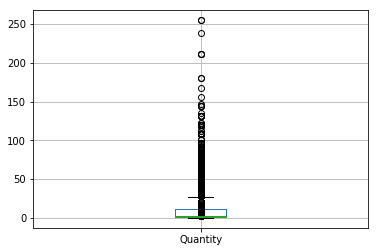

In [142]:
#features to consider: number of dogs in image, age, breed, mixed breed?, quantity, fee, state
#(definitely image is part but thats a separate analysis)

boxplot=train_data.boxplot(column='Age')
boxplot1=train_data.boxplot(column='Quantity')
#to remove outliers for age
#train_age_out = train_data[~((train_data < (Q1 - 1.5 * IQR)) |(train_data > (Q3 + 1.5 * IQR))).any(axis=1)]
#train_age_out 


In [143]:
# dropping ALL duplicate values 
train_data.drop_duplicates(subset ="PetID", 
                     keep = False, inplace = True) 
train_data.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [144]:
##choosing the right features so as to reduce risk of overfitting and noise
#Univariate Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

features = ['Type','Age','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','Quantity','Fee','State','VideoAmt','PhotoAmt']
X = train_data[features]  #independent columns
y = train_data.iloc[:,-1]    #target column i.e price range

# Feature extraction
test = SelectKBest(score_func=chi2, k=6)
fit = test.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print 10 best features

#features = fit.transform(X)
# Summarize selected features
#print(features[0:5,:])

[2.761e+01 6.338e+03 2.991e+03 6.714e+03 1.407e+01 4.743e+01 5.912e+01
 2.518e+01 6.262e+00 3.507e+01 1.708e+01 1.507e+01 2.018e+01 8.488e-01
 9.974e+01 2.678e+02 1.059e+00 3.366e+01 8.872e+02]
       Specs        Score
3     Breed2  6714.057603
1        Age  6338.200463
2     Breed1  2991.321460
18  PhotoAmt   887.185508
15       Fee   267.807370
14  Quantity    99.739520


In [145]:
#using selected features to train the data
#split data for training and validation
from sklearn.model_selection import train_test_split

y = train_data.AdoptionSpeed
features=['Breed2','Age','Breed1','PhotoAmt','Fee']
X = train_data[features]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
#print(train_X, val_X, train_y, val_y)

In [147]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

def get_mae(max_leaf_nodes, train_X=train_X, val_X=val_X, train_y=train_y, val_y=val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [148]:
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [17,18,19,20]:
    my_mae = get_mae(max_leaf_nodes)
    print(max_leaf_nodes, my_mae)

17 0.9317795294605058
18 0.9315136490172379
19 0.9322689625630127
20 0.9338471639635324


In [149]:
#predict
import math
from sklearn.metrics import accuracy_score

# ----- xgboost ------------
# install xgboost
# 'pip install xgboost' or https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform/39811079#39811079

from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(train_X, train_y)
pred_y = model.predict(val_X)

pred_y = np.round(pred_y)
pred_y = pred_y.astype(int)
#print(len(test_predictions),len(val_y))

##checking accuracy
accuracy = accuracy_score(val_y,pred_y)*100

print(accuracy)

38.83702320618831


In [151]:
#predict with test data

test_predictions = model.predict(test_data[features])
test_predictions = np.round(test_predictions)
test_predictions = test_predictions.astype(int)

prediction_df = pd.DataFrame({'PetID' : test_data['PetID'],
                              'AdoptionSpeed' : test_predictions})
prediction_df.head()
#test_predictions

prediction_df.to_csv('submission.csv', index=False)